# Chapter 11: Training deep neural networks

- Common problems and solutions with training deep networks at a glance: <br>

| Problem                       | Solution                                                                                  |
| :---------------------------- | :---------------------------------------------------------------------------------------- |
| Vanishing/exploding gradients | Different initialization, activation functions, batch normalization and gradient clipping |
| Limited data                  | Transfer learning and unsupervised learning                                               |
| Slow training                 | Use of different optimizers                                                               |
| Overfitting                   | Use regularization techniques                                                             |

In [155]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from scipy.special import erfc

%matplotlib inline

## Vanishing/exploding gradient problem

- In deep learning, gradients can get unstable during training process, leading to layers learning at a different rate: 
     - Vanishing gradient: When the gradient of the loss function become too small for the algorithm to make progress
     - Exploding gradient: When the gradient of the loss function become too large, and the algorithm diverges. 

- Glorot and Bengio discovered that the sigmoid function (with $\mu$ of 0.5) and weight initialization technique (i.e., $\mu$ of 0 and $\sigma$ of 1) can lead to problems with the gradient --> this combination causes the output of the $\sigma^2$ to be larger than $\sigma^2$ of input, which saturates as the algorithm goes forward in the network. 

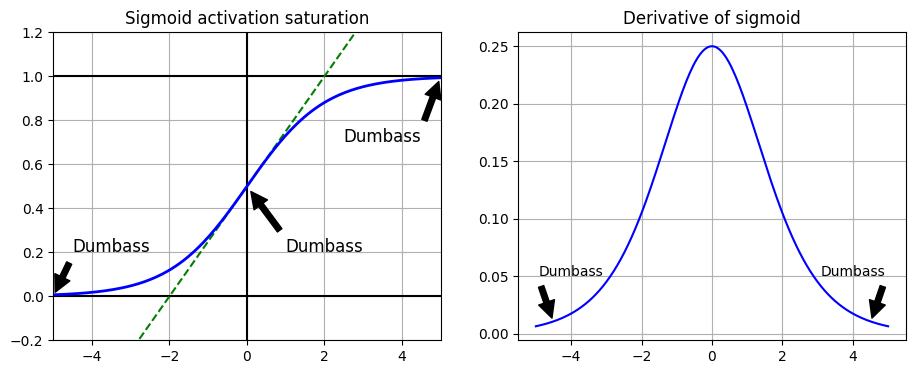

In [108]:
z = np.linspace(-5, 5, 200)
props = dict(facecolor='black', shrink=0.1)
sigmoid = lambda x: 1 / (1 + np.exp(-x))
dev_sigmoid = lambda x: sigmoid(x) * (1 - sigmoid(x))

plt.figure(figsize=(11, 4))
plt.subplot(121)
plt.plot([-5, 5], [1, 1], 'k-')
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-0.75, 1.75], 'g--')
plt.plot(z, sigmoid(z), 'b-', linewidth = 2)
plt.annotate('Dumbass', xytext = (3.5, 0.7), xy = (5, 1), arrowprops=props, fontsize = 12, ha = "center")
plt.annotate('Dumbass', xytext = (-3.5, 0.2), xy = (-5, 0), arrowprops=props, fontsize = 12, ha = "center")
plt.annotate('Dumbass', xytext = (2, 0.2), xy = (0, 0.5), arrowprops=props, fontsize = 12, ha = "center")
plt.grid(True)
plt.title("Sigmoid activation saturation")
plt.axis([-5, 5, -0.2, 1.2])

plt.subplot(122)
plt.plot(z, dev_sigmoid(z), 'b-')
plt.title("Derivative of sigmoid")
plt.annotate('Dumbass', xytext = (-4, 0.05), xy = (-4.5, 0.01), arrowprops=props, fontsize = 10, ha = "center")
plt.annotate('Dumbass', xytext = (4, 0.05), xy = (4.5, 0.01), arrowprops=props, fontsize = 10, ha = "center")
plt.grid(True)
plt.show()

### Solution 1: Glorot, He, and Lecun initialization

Glorot initialization:

- $\sigma^2$ of output = $\sigma^2$ of input, and gradients need to have be equal to $\sigma^2$ before and after flowing through a layer in reverse direction to prevent vanishing/exploding gradient. But, this is not ossible unless the layer has an equal number of inputs and neurons (i.e., $\text{fan}_\text{in} = \text{fan}_\text{out}$)
- Glorot and Bengio proposed that the connection weights of each layer must be initialized randomly using the following: <br>
  1.  A normal distribution with $\mu = 0$ and $\sigma^2$ = $\displaystyle\frac{1}{\text{fan}_\text{avg}}$ <br>
  2.  A uniform distribution between $-r$ and $+r$, with $r = \displaystyle\sqrt{\frac{3}{\text{fan}_\text{avg}}}$, where $\text{fan}_\text{avg} = (\text{fan}_\text{in} + \text{fan}_\text{out}) / 2$

Other initialization methods and comparison to Glorot initialization

| Initialization |     Activation functions      |  $\sigma^2$ (Normal distribution)   |      $\pm$ r (Uniform distribution)      |
| :------------: | :---------------------------: | :---------------------------------: | :--------------------------------------: |
|     Glorot     | None, tanh, logistic, softmax |  $\displaystyle\frac{1}{\text{fan}_\text{avg}}$  | $\displaystyle\sqrt{\frac{3}{\text{fan}_\text{avg}}}$ |
|       He       |     ReLU and its variants     |  $\displaystyle\frac{2}{\text{fan}_\text{in}}$   | $\displaystyle\sqrt{\frac{6}{\text{fan}_\text{in}}}$  |
|     LeCun      |             SELU              | $\displaystyle\frac{1}{\text{fan}_\text{in}}$ \* | $\displaystyle\sqrt{\frac{3}{\text{fan}_\text{in}}}$  |

\*: preferred,

Initialization in Tensorflow:

- TF uses Glorot initialization with uniform distribution by default. Initializers are passed as an argument into the individual layers when building the model or instantiated by calling `keras.initializers.[initializer](**args)`. For example:

```python
# method 1, keyword
keras.layers.Dense(10, activation = "relu", keras_initializer = "he_normal")

# method 2, using He initialization but based on a uniform distribution w/fan_in
he_avg_init = keras.initializers.VarianceScaling(scale = 2., mode = 'fan_avg', distribution = "uniform")
keras.layers.Dense(10, activation = "relu", keras_initializer = he_avg_init)
```

- Other methods available as keyword arguments, as demonstrated below:

In [10]:
[i for i in dir(keras.initializers) if not i.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

### Solution 2: Non-saturating activation functions

- Problems with ReLU is that neurons can "die" (they produce 0s consistently), which causes GD to stop working effectively since the derivative of ReLU will always be zero for negative inputs.
- Variants of ReLU:<br>

  1.  LeakyReLU: $\text{max}(\alpha z, z)$<br>
      a. Randomized leaky ReLU (RReLU): The $\alpha$ in LeakyReLU is set to random in a given range during training and is set to an average value during testing. <br>
      b. Parametric leaky ReLU (PReLU): $\alpha$ can be learned during training and modifiable by backpropagation. --> usually performs better on large image datasets <br>
  2.  Exponential linear unit (ELU): Given by: <br>
      $\begin{cases}
      \alpha ( \text{exp} (z) - 1) && \text{if} z < 0 \\
      z && \text{if} z \geq 0
      \end{cases} $ <br>
      $\alpha$ defines the value ELU approaches when z is a large negative number, usually set to 1 (so output will be aroud -1) so that the function is smooth everywhere. However, ELU can be slow to compute <br>
      a. Scaled ELU: [Klambauer et al. (2017)](https://arxiv.org/pdf/1706.02515.pdf) discovered that staking dense layers with SELU, the network could self-normalize (the output of the network has a $\mu$ of 0 and $\sigma$ of 1). Self-regularization must meet the following condition: <br>
      - Input features must be standardized<br>
      - Weights must be initialized with LeCun normal initialization <br>
      - Network must be sequential and all layers must be dense.

- General rule of thumb when choosing activation functions and few other considerations: <br>
  1. In general: SELU > ELU > leaky ReLU > ReLU > tanh > logistic
  2. Few other considerations: <br>
     $\begin{cases} 
  \text{ELU > SELU} && \text{If network architecture prevents it from self-normalizing}  \\
    \text{LeakyReLU} && \text{If Runtime latency is an issue} \\
    \text{RReLU and PReLU} && \text{If there is enough computer power / data}
  \end{cases}$


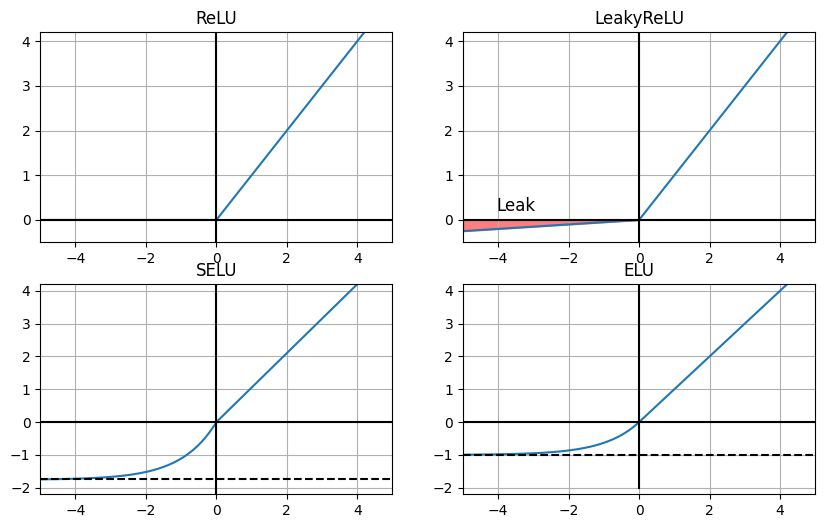

In [157]:
leaky_relu = lambda z, alpha=0.05:np.maximum(alpha * z, z)
relu = lambda z:np.maximum(0, z)
elu = lambda z, alpha=1: np.where(z < 0, alpha * (np.exp(z) - 1), z)

alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)
selu = lambda z, scale=scale_0_1, alpha=alpha_0_1:scale * elu(z, alpha)

plt.figure(figsize=(10,6))
plt.subplot(221) # ReLU
plt.plot(z, relu(z))
plt.plot([0,0], [-1,5], "k-");plt.plot([-5,5], [0,0], "k-")
plt.axis([-5, 5, -0.5, 4.2]); plt.grid(True)
plt.title("ReLU")

plt.subplot(222) # LeakyReLU
plt.title("LeakyReLU")
plt.plot(z, leaky_relu(z))
plt.annotate("Leak", xytext=(-3.5, 0.2), xy=(-5, 0.02), fontsize=12,ha="center")
plt.fill_between(np.linspace(-5, 0, 100), leaky_relu(z)[leaky_relu(z) < 0], color = 'red', alpha = 0.5)
plt.plot([0,0], [-1,5], "k-");plt.plot([-5,5], [0,0], "k-")
plt.axis([-5, 5, -0.5, 4.2]); plt.grid(True)

plt.subplot(223) # SELU
plt.title("SELU")
plt.plot(z, selu(z))
plt.plot(z, [min(keras.activations.selu(z))] * len(z), 'k--')
plt.plot([0,0], [-5,5], "k-");plt.plot([-5,5], [0,0], "k-")
plt.axis([-5, 5, -2.2, 4.2]); plt.grid(True)


plt.subplot(224) # ELU
plt.title("ELU")
plt.plot(z, elu(z))
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0,0], [-2,5], "k-"); plt.plot([-5,5], [0,0], "k-")
plt.axis([-5, 5, -2.2, 4.2]); plt.grid(True)

plt.show()

In [160]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print(f"Layer {layer}: mean {means:.2f}, std deviation {stds:.2f}")

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


### Solution 3: Batch normalization (BN)

- Standardizes the input to have a $\mu$ of 0 and $\sigma$ of 1, and shift the result using two paraeter vectors per layer: one for scaling and one for shifting --> lets the network learn the best scale and mean of each layer's input.
- BN considerably improves vanishing gradient problem, makes network less sensitive to weight initialization, and acts as a regulizer. 
- Algorithm:

| #   |                                        Formula                                        | Explanation                                          |
| :-- | :-----------------------------------------------------------------------------------: | :--------------------------------------------------- |
| 1   |          $\mu_B = \displaystyle\frac{1}{m_B}\sum\limits^{m_B}_{i=1}x^{(i)}$           | Vector of mean of mini-batch $B$                     |
| 2   | $\sigma_B^2 = \displaystyle\frac{1}{m_B}\sum\limits^{m_B}_{i = 1}(x^{(i)} - \mu_B)^2$ | Vector of SD of mnibatch $B$                         |
| 3   |   $\hat{x}^i = \displaystyle\frac{x^{(i)}-\mu_B}{\sqrt{(\sigma_B^2 + \epsilon)}} $    | Normalized and zero-centered inputs for instance $i$ |
| 4   |                   $z^{(i)} = \gamma \otimes \hat{x}^{(i)}  + \beta$                   | Output                                               |

$m_B$ is the number of instances in mini-batch <br>
$\gamma$ is the output scaling parameter vector of the layer (one scaling parameter per input)<br>
$\beta$ is the output shifting parameter vector of the layer (one shifting parameter per input)<br>
$\otimes$ is element-wise operation<br>
$\epsilon$ is a scaling factor (usually set to `1e-5`)

$\gamma$ and $\beta$ are learned through backpropagation, $\mu$ and $\sigma$ are estimated using exponential moving average during training and used after training - they are not affected by backpropagation, so tensorflow classify $\mu$ and $\sigma$ as "non-trainable". 

- hyperparameters: <br>
     1. Momentum: Used when updating moving averages - the layer updates the running average $\hat{v}$ given new input $v$ by: $\hat{v}\leftarrow \hat{v} \times \text{momentum} + v \times (1 - \text{momentum}) $
     2. axis: Determines the axis to be normalized, with a defult of -1 (last axis)
     
- Problems with BN: Adding model complexity. However, this can be solved by fusing BN layer with the previous layer by updating the previous layer's weights and biases so that it directly produces outputs of the appropriate scale and offset. 

In [162]:
# Implementation in keras

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(name = "BN1"),
    keras.layers.Dense(300, activation="elu", kernel_initializer = "he_normal"),
    keras.layers.BatchNormalization(name = "BN2"),
    keras.layers.Dense(100, activation = "elu", kernel_initializer = "he_normal"),
    keras.layers.BatchNormalization(name = "BN3"),
    keras.layers.Dense(10, activation = "softmax")
])

model.summary()

# To verify that mu and sigma are not trainable: 
print(f"{[(var.name, var.trainable) for var in model.layers[1].variables]}")

Model: "BN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_18 (Flatten)        (None, 784)               0         
                                                                 
 BN1 (BatchNormalization)    (None, 784)               3136      
                                                                 
 dense_51 (Dense)            (None, 300)               235500    
                                                                 
 BN2 (BatchNormalization)    (None, 300)               1200      
                                                                 
 dense_52 (Dense)            (None, 100)               30100     
                                                                 
 BN3 (BatchNormalization)    (None, 100)               400       
                                                                 
 dense_53 (Dense)            (None, 10)                1010     

In [164]:
# There is debate as to whether applying BN before the activation function works better. 
# The layer before BN does not need to have bias terms, which causes waste of parameters --> use_bias = False

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(name = "BN1"),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(name = "BN2"),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(name = "BN3"),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation = "softmax")
])

### Solution 4: Gradient clipping

